In [65]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd 
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
import seaborn

import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Data preprocessing

In [148]:
data_mat = pd.read_csv("./data/student/student-mat.csv", sep=";")
data_por = pd.read_csv("./data/student/student-por.csv", sep=";")

data = pd.concat([
        pd.concat([data_mat, pd.DataFrame(np.ones((data_mat.shape[0], 1)), columns=["Course"])], axis=1),
        pd.concat([data_por, pd.DataFrame(np.zeros((data_por.shape[0], 1)), columns=["Course"])], axis=1),
    ], axis=0)

binary_features = []
categorical_features = []
numerical_features = []

for column in data.columns:
    if len(data[column].unique()) == 2:
        binary_features.append(column)
    elif len(data[column].unique()) < 10:    # 10 is a magic number, but it fits to the current dataset
        categorical_features.append(column)
    else:
        numerical_features.append(column)
        
binary_features = \
    ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 
     'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
     'romantic', 'Course']
binary_vectors = pd.get_dummies(data[binary_features], drop_first=True).astype(np.int8)

categorical_features = \
    ['age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 
     'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
     'goout', 'health']
label_vectors = pd.get_dummies(data[categorical_features].astype(object)).astype(np.int8)

numerical_features = ['absences', 'G1', 'G2', 'G3']
numerical_features = data[numerical_features].astype(np.int8)
numerical_features = (numerical_features - numerical_features.mean()) / numerical_features.std()

X = pd.concat([binary_vectors, label_vectors, numerical_features], axis=1)
Y = data[["Dalc", "Walc"]].astype(np.int8)

Here we will barely get well-separated clusters. Moreover, most of features here are binary, it complicates clustering based on metrics requiring to use a sophisticated one. However, we are able to use hierarchical approach, e.g. AgglomerativeClustering.

In [86]:
clustering = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
labels = clustering.fit_predict(pd.concat([X, Y], axis=1))

So as to plot results let's use dimensionality reduction technique.

In [87]:
pca = PCA()
X_pca = pca.fit_transform(X)

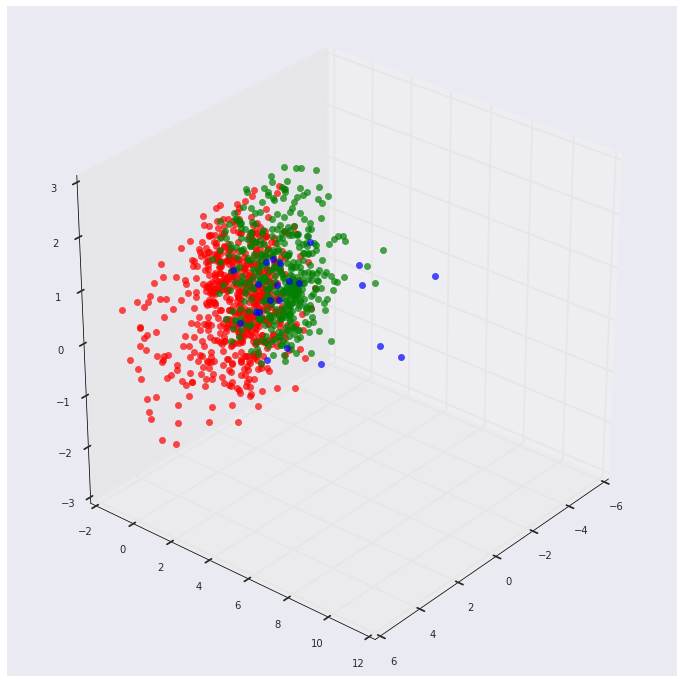

In [88]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y']

for label, color in zip(np.unique(labels), colors):
    sel = labels == label
    ax.plot(X_pca[sel, 0], X_pca[sel, 1], X_pca[sel, 2], linestyle='', marker='o', color=color, alpha=.7)
    
    
ax.view_init(30, 40)

This plot helps a little while interpreting data, because we use linear combinations of our features, so probably it's better to cluster by hand.

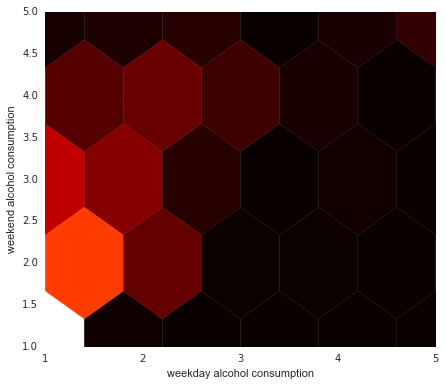

In [106]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.hexbin(Y.ix[:, 0], Y.ix[:, 1], gridsize=5, cmap='hot');
ax.set_xlabel("weekday alcohol consumption");
ax.set_ylabel("weekend alcohol consumption");

We can see that remarkable part of students consume very little alcohol.  
Another part can be described as "moderate" consumption.  
And 'outsider' part: very high consumption without concerns about day of week.  

In [121]:
X_low.ix[1, :]

,Course,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,...,goout_5,health_1,health_2,health_3,health_4,health_5,absences,G1,G2,G3
1,1,0,0,1,0,1,0,1,0,0,...,0,0,0,1,0,0,-0.070027,-2.082729,-1.901380,-1.382209
1,0,0,0,1,0,1,0,1,0,0,...,0,0,0,1,0,0,-0.392087,-0.741974,-0.074936,-0.088479


In [144]:
X_low = X.ix[(Y.ix[:, 0] == 1) & (Y.ix[:, 1] == 1)]
X_med = X.ix[(Y.ix[:, 0] >= 2) & (Y.ix[:, 0] <= 3) & (Y.ix[:, 1] >= 2) & (Y.ix[:, 0] <= 4)]
X_high = X.ix[(Y.ix[:, 0] >= 4) & (Y.ix[:, 0] >= 4)]

distance_lm = X_low.describe().ix[1, :] - X_med.describe().ix[1, :]
distance_mh = X_med.describe().ix[1, :] - X_high.describe().ix[1, :]

In [141]:
pd.Series(sorted(distance_lm, key=lambda x: -np.abs(x)), index=distance_lm.index)[:10]

Course            0.289749
school_MS         0.284019
sex_M            -0.276461
address_U         0.270294
famsize_LE3      -0.261407
Pstatus_T        -0.217185
schoolsup_yes    -0.162345
famsup_yes        0.160712
paid_yes         -0.141472
activities_yes    0.137635
dtype: float64

In [143]:
pd.Series(sorted(distance_mh, key=lambda x: -np.abs(x)), index=distance_mh.index)[:10]

Course           -0.294809
school_MS         0.279754
sex_M            -0.261538
address_U        -0.242308
famsize_LE3       0.227135
Pstatus_T         0.212968
schoolsup_yes    -0.173077
famsup_yes        0.150000
paid_yes         -0.142308
activities_yes   -0.134615
dtype: float64

So, one can come up with some hand-crafted clusters here. We can use features with the highest mean differences in order to do so. For instance, we can see that students attending tends to have low or high level of alcohol consumption, whereas guys from Portuguese courses tend to have moderate level. Similar thing appears for urban/rural distinction. 